<a href="https://colab.research.google.com/github/Patricklinfz/AB-test-ecommerce-webpage/blob/master/PrimeVideo_project_by_Patrick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

This project will dive deep on looking into the possible contributing factors of Prime Video customer view time per day, building predictive models. Suggestions will be offered based upon analysis. 

# Part 0 Load packages, load data


In [ ]:
#import neccessary libraries
import numpy as np
import pandas as pd
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# set up table display setting
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

## 0.1 Data Source: TVdata.txt

In [ ]:
#load data
from google.colab import files
uploaded = files.upload()

Saving TVdata.txt to TVdata.txt


In [ ]:
# read data into pandas dataframe
df=pd.read_table('TVdata.txt',header=0,sep=',',lineterminator='\n')
# display the first few rows
print(df.head()) # df has too many columns. To avoid scrolling back and forth, use print to display

   video_id  cvt_per_day  weighted_categorical_position  \
0    385504   307127.606                              1   
1    300175   270338.426                              1   
2    361899   256165.867                              1   
3    308314   196622.721                              3   
4    307201   159841.652                              1   

   weighted_horizontal_poition  import_id  release_year  \
0                            3  lionsgate          2013   
1                            3  lionsgate          2013   
2                            3      other          2012   
3                            4  lionsgate          2008   
4                            3  lionsgate          2013   

                                          genres  imdb_votes    budget  \
0                          Action,Thriller,Drama       69614  15000000   
1                          Comedy,Crime,Thriller       46705  15000000   
2                                    Crime,Drama      197596  260000

# Part 1: Data Exploration

## 1.1 Exclude erroneous data

Each video should only appear once in the list, duplicated video will be removed.

In [ ]:
if df['video_id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


## 1.2 Understand numerical features

### 1.2.1 Overview

In [ ]:
# get a highlevel overview of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

There is no null in any column.
`video_id` and `release_year` are both in integer datatype. 
`video_id` is not a feature of interest.
`release_year` feature will serve better in analysis by transforming into a categorical feature. Will leave it for the next part: Understand categorical features

In [ ]:
# get a summary statistics for all numerical features I am interested in
print(df.drop(columns = ['video_id','release_year']).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
# get the proportion of 0 value for the numerical features
(df==0).sum(axis=0)/df.shape[0]

       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
95%      14692.834                         22.000   
max     307127.606                         41.000   

       weighted_horizontal_poition  imdb_votes        budget     boxoffice  \
count                     4226.000    4226.000      4226.000      4226.000   
mean                        28.104    6462.924   2150743.439   2536338.472   
std                         11.864   31596.007   7176604.483   8243516.266   
min                          1.000       0.000         0.000         0.000   
10%                       

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64

In [ ]:
for col in df.columns:
  if (df[col]==0).sum(axis=0)/df.shape[0] > 0.3:
    print(col)

budget
boxoffice
metacritic_score
star_category


`budget`, `boxoffice`, `metacritic_score`, `star_category` have over 30% of 0 values, which is reasonable to consider them missing values.

### 1.2.2 `cvt_per_day` feature

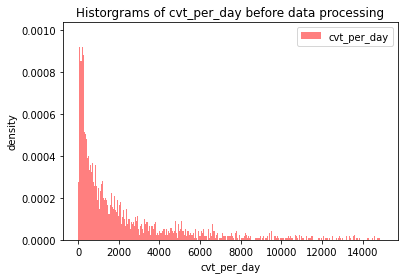

In [ ]:
# plot a histogram to understand the distribution of 'cvt_per_day'
plt.hist(df['cvt_per_day'],bins=range(0,15000,30),color='r',label='cvt_per_day', density=True, alpha=0.5)
plt.title('Historgrams of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

### 1.2.3 Correlation among numerical features

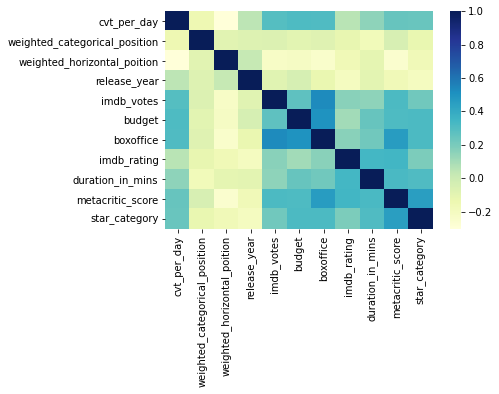

In [ ]:
corr = df[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [ ]:
print(corr)

                               cvt_per_day  weighted_categorical_position  \
cvt_per_day                          1.000                         -0.148   
weighted_categorical_position       -0.148                          1.000   
weighted_horizontal_poition         -0.302                         -0.084   
release_year                         0.046                         -0.069   
imdb_votes                           0.298                         -0.064   
budget                               0.316                         -0.090   
boxoffice                            0.312                         -0.074   
imdb_rating                          0.059                         -0.116   
duration_in_mins                     0.152                         -0.174   
metacritic_score                     0.249                         -0.044   
star_category                        0.247                         -0.123   

                               weighted_horizontal_poition  release_year  \

## 1.3 Understand categorical features

### 1.3.1 Distribution of standard categorical features

In [ ]:
std_categorical = ['import_id', 'awards', 'mpaa']
for col in std_categorical:
  print('{} has {} distinct categories'.format(col, df[col].nunique()))

import_id has 4 distinct categories
awards has 5 distinct categories
mpaa has 6 distinct categories


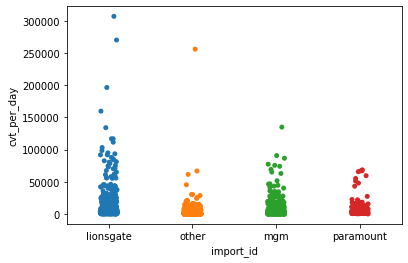

other       0.701
lionsgate   0.160
mgm         0.105
paramount   0.033
Name: import_id, dtype: float64


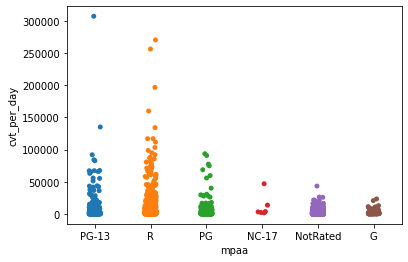

NotRated   0.511
R          0.274
PG-13      0.101
PG         0.084
G          0.030
NC-17      0.001
Name: mpaa, dtype: float64


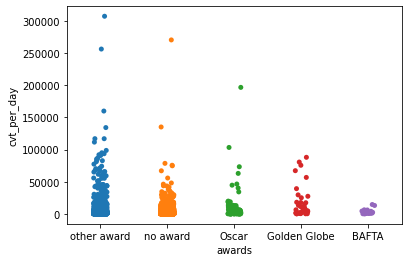

no award       0.608
other award    0.344
Oscar          0.033
Golden Globe   0.010
BAFTA          0.004
Name: awards, dtype: float64


In [ ]:
# draw a stripplot for the distribution of these 3 features
sns.stripplot(x='import_id', y='cvt_per_day', data=df,jitter=True)
plt.show()
print(df['import_id'].value_counts()/df['import_id'].count())

sns.stripplot(x='mpaa', y='cvt_per_day', data=df,jitter=True)
plt.show()
print(df['mpaa'].value_counts()/df['import_id'].count())

sns.stripplot(x='awards', y='cvt_per_day', data=df, jitter=True)
plt.show()
print(df['awards'].value_counts()/df['import_id'].count())

### 1.3.2 Distribution of splited genres

Videos can have more than 1 genre. But I assume different genres have different effect on a video's cvt_per_day. So I split the genres of each video to help understand the effect of each individual genre.


Drama                    1677
Comedy                   1184
Thriller                  879
Horror                    762
Action                    739
Documentary               671
Romance                   591
Crime                     437
Independent               393
Mystery                   375
Adventure                 363
Sci-Fi                    363
Kids & Family             280
Fantasy                   243
Music                     171
Animation                 129
War                       102
Western                   102
Sport                      77
Musicals                   68
Foreign/International      64
Anime                      11
Reality                     9
Lifestyle                   7
Adult                       3
LGBT                        2
Holiday                     1
dtype: int64


Text(0.5, 1.0, 'Bar chart of genres before data processing')

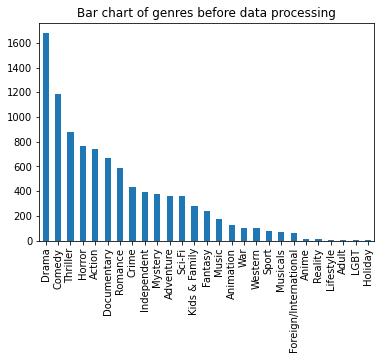

In [ ]:
# split from a collection of genres into individual genre for each video
gen_split = df['genres'].str.get_dummies(sep=',').sum()
print(gen_split.sort_values(ascending=False))
# draw 
gen_split.sort_values(ascending=False).plot.bar()
plt.title('Bar chart of genres before data processing')

### 1.3.3 Distribution of release_year

In [ ]:
# check the percentitles 
print(df['release_year'].describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
25%     1998.000
50%     2008.000
75%     2012.000
95%     2015.000
max     2017.000
Name: release_year, dtype: float64


In [ ]:
# check the unique values of release_year
df['release_year'].nunique()

97

There is a wide range for release years. I assume released year can play a role in a video's popularity. Generally, a video become less popular over time, of course with exception of all-time favorites. I check its distribution.

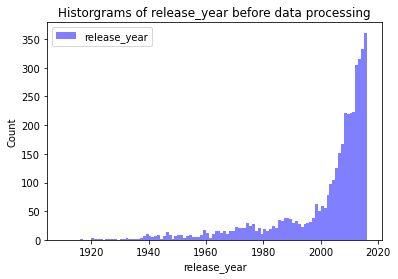

In [ ]:
plt.hist(df['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='b', label = 'release_year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('Count')
plt.show()

# Part 2: Feature Preprocessing

After Exploratory Data Analysis, I move on to data cleaning and preprocessing.
3 steps included:
1. encode the categorical features;
2. impute missing values for both numeric and categorical feature;
3. scale out features for the sake of better model performance.


## 2.1 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy variables.

1. The first 3 have relatively small amount of unique values, they can be  easily converted to dummies.

2. The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to Part 1.3.2). So I group these 6 minority sub-types together.

3. The release_year is binned into 10 buckets based on the year range.

In [ ]:
# Convert 3 standard categorical variables into dummy variables
d_import_id = pd.get_dummies(df['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(df['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(df['awards']).astype(np.int64)

In [ ]:
# Convert 'genres' into dummy variables
d_genres=df['genres'].str.get_dummies(sep=',').astype(np.int64)
d_genres['Misc_genres']=d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(columns = ['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True)

In [ ]:
# get the range info of release_year
print(df['release_year'].describe())
df['release_year'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count   4226.000
mean    2001.057
std       17.497
min     1916.000
25%     1998.000
50%     2008.000
75%     2012.000
max     2017.000
Name: release_year, dtype: float64


0.100   1974.000
0.200   1991.000
0.300   2001.000
0.400   2006.000
0.500   2008.000
0.600   2010.000
0.700   2012.000
0.800   2013.000
0.900   2014.000
Name: release_year, dtype: float64

In [ ]:
# bin release_year and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014, 2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(df['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [ ]:
# drop the previous categorical features, add new dummy variables
temp_df=df.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)

new_df = pd.concat([temp_df, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
new_df.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,1,3,69614,15000000,42930462,6.500,112.301,51,1.710,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,1,3,46705,15000000,3301046,6.500,94.983,41,3.250,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,1,3,197596,26000000,37397291,7.300,115.764,58,2.647,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,3,4,356339,15000000,15700000,7.600,130.704,94,1.667,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,1,3,46720,27220000,8551228,6.400,105.546,37,3.067,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# check null
res = new_df.isnull().sum().any()
if not res:
  print('no null value')

no null value


## 2.2 Missing data

I need to deal with the missing data. According to the data info (refer to Part 1.2.1), there is no null value in our dataset.
That's good. However, large amount of zero value in a certain column can be a very good candidate for missing data. 
So we have the check the ratio of zero value in our numeric features.

In [ ]:
# get the proportion of 0 value for the numerical features
print((df==0).sum(axis=0)/df.shape[0])

print('##########')
for col in df.columns:
  if (df[col]==0).sum(axis=0)/df.shape[0] > 0.3:
      print(col)


video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64
##########
budget
boxoffice
metacritic_score
star_category


Among the 10 numerical features (not include video_id), 6 features have a proportion of zero value. 

4 features have over 30% of missing values (although they are not null, but instead shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 

2 features have less than 10% of missing data: imdb_votes, imdb_rating. It could be due to no vote/no rating for a movie, which is possible when a video is extremely unpopular. So I won't consider 0 value in these 2 columns missing values.

In [ ]:
# replace 0 with Null in 4 columns with large amount of 0 value
new_df[['budget','boxoffice','metacritic_score', 'star_category']] = new_df[['budget','boxoffice','metacritic_score', 'star_category']].replace(0, np.nan)
new_df[['budget','boxoffice','metacritic_score', 'star_category']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   budget            1772 non-null   float64
 1   boxoffice         1032 non-null   float64
 2   metacritic_score  1214 non-null   float64
 3   star_category     2380 non-null   float64
dtypes: float64(4)
memory usage: 132.2 KB


With such large amount of missing value, drop null is not an option at all. That will scarifice many valuable data. Instead, I will fill missing data with mean value.

In [ ]:
new2=new_df.copy()
new2['boxoffice']=new_df['boxoffice'].fillna(new_df['boxoffice'].mean())
new2['metacritic_score']=new_df['metacritic_score'].fillna(new_df['metacritic_score'].mean())
new2['star_category']=new_df['star_category'].fillna(new_df['star_category'].mean())
new2['budget']=new_df['budget'].fillna(new_df['budget'].mean())
new2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   imdb_votes                     4226 non-null   int64  
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  lionsgate                      4226 non-null   int64  
 12  mgm                            4226 non-null   i

## 2.3 Feature scaling

There are two most common used scaling methods: normalization, and standardscaler.
Given there is no specific requirement for the range of output, we choose to use standardscaler.

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [ ]:
new2.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,1,3,69614,15000000.000,42930462.000,6.500,112.301,51.000,1.710,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,1,3,46705,15000000.000,3301046.000,6.500,94.983,41.000,3.250,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,1,3,197596,26000000.000,37397291.000,7.300,115.764,58.000,2.647,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,3,4,356339,15000000.000,15700000.000,7.600,130.704,94.000,1.667,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,1,3,46720,27220000.000,8551228.000,6.400,105.546,37.000,3.067,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
new_sc = new2.copy()

sc_scale = preprocessing.StandardScaler().fit(new_sc[scale_lst])
new_sc[scale_lst] = sc_scale.transform(new_sc[scale_lst])
new_sc.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.999,1.470,4.696,0.586,1.079,-0.630,0.033,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.274,1.470,-1.022,0.586,0.257,-1.997,3.434,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.050,3.108,3.898,0.962,1.243,0.327,2.102,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.075,1.470,0.767,1.104,1.952,5.250,-0.063,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.274,3.290,-0.265,0.538,0.758,-2.544,3.029,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# MinMax scaling
new_mm = new2.copy()
mm_scale = preprocessing.MinMaxScaler().fit(new_mm[scale_lst])
new_mm[scale_lst] = mm_scale.transform(new_mm[scale_lst])
new_mm.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,0.000,0.029,0.073,0.140,0.233,0.650,0.447,0.505,0.237,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,0.000,0.029,0.049,0.140,0.018,0.650,0.376,0.404,0.750,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,0.000,0.029,0.208,0.243,0.203,0.730,0.462,0.576,0.549,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,0.050,0.043,0.376,0.140,0.085,0.760,0.523,0.939,0.222,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,0.000,0.029,0.049,0.254,0.046,0.640,0.419,0.364,0.689,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Robust scaling
new_rs = new2.copy()
rs_scale = preprocessing.RobustScaler().fit(new_mm[scale_lst])
new_rs[scale_lst] = rs_scale.transform(new_rs[scale_lst])
new_rs.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category,lionsgate,mgm,other,paramount,G,NC-17,NotRated,PG,PG-13,R,BAFTA,Golden Globe,Oscar,no award,other award,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,Independent,Kids & Family,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Misc_genres,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,7.000,11.250,22220029.706,442239385.753,42930461.944,23.680,1602.964,50.448,36.925,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,7.000,11.250,14907726.654,442239385.753,3301045.944,23.680,1354.983,40.448,75.390,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,7.000,11.250,63070488.878,766548269.676,37397290.944,26.880,1652.548,57.448,60.320,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,23.000,15.562,113739523.901,442239385.753,15699999.944,28.080,1866.480,93.448,35.842,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,7.000,11.250,14912514.490,802517073.165,8551227.944,23.280,1506.229,36.448,70.811,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


# Part 3: Model Training

In [ ]:
# split data into training & testing data
train, test = train_test_split(new_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(columns = ['video_id', 'cvt_per_day'])
model_test_x = test.drop(columns = ['video_id', 'cvt_per_day'])
model_train_y = train['cvt_per_day']
model_test_y = test['cvt_per_day']

### 3.1 Lasso linear regression

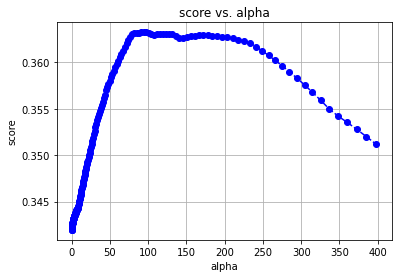

The optimaized alpha and score of Lasso linear is: 94.05173990569547, 0.3632305058944092


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# split training data into training & validating data
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)
lr_train_x = lr_train.drop(columns = ['video_id', 'cvt_per_day'])
lr_validate_x = lr_validate.drop(columns = ['video_id', 'cvt_per_day'])
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']


alphas = np.logspace (-0.3, 2.6, num=200)
scores = np.empty_like(alphas) # create an array of uninitialized data with same shape, same type as alphas
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y) # get the coefficient of determination R^2 of the prediction
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: {}, {}'.format(opt_a, max_score))

In [ ]:
# combine the splited 85% training data & 15% validate data, use the optimal alpha, and re-train the model with all training data available
# lasso_f is the Lasso model to be tested with testing data.
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)


Lasso(alpha=94.05173990569547, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 3.2 Ridge linear regression

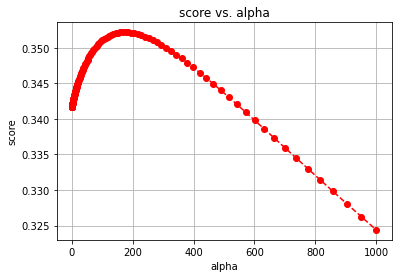

The optimaized alpha and score of Ridge linear is: 


(None, 176.59559477043035, 0.3522121699004048)

In [ ]:
# Use the same training data set as Lasso 
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.logspace (-0.3, 3, num=150)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
      
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [ ]:
# combine splited training data & validate data (meaning, all training data available), use the optimal alpha, re-train the model
# ridge_f is the Ridge regression model to be tested with testing data.
ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

Ridge(alpha=176.59559477043035, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

##3.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# create a based model
rf=RandomForestRegressor(random_state=2,max_features='sqrt',n_jobs=-1)
# define parameter grid
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
# instantiate the grid search model
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

{'mean_fit_time': array([0.42004995, 0.4253448 , 0.45523119, 0.44396806, 0.42046123,
       0.44110475, 0.43992996, 0.42488608, 0.44491072, 0.42818594,
       0.42646437, 0.40980496, 0.44144263, 0.43701205, 0.4418159 ,
       0.41424785, 0.44949627, 0.41840048, 0.44361825, 0.44221587,
       0.45431533, 0.44894133, 0.41952   , 0.38310285, 0.44125037,
       0.44081511, 0.39244828, 0.44089046, 0.4419549 , 0.42444301,
       0.44171329, 0.45883331, 0.4570787 , 0.40544162, 0.43525219,
       0.42397156, 0.42534986, 0.4432765 , 0.4454237 , 0.45497875,
       0.45366659, 0.45725031, 0.49059172, 0.52800021, 0.43698349,
       0.43817878, 0.4129261 , 0.44206934, 0.45383792, 0.44848123,
       0.45570498, 0.45643635, 0.47809081, 0.46690416, 0.50881062,
       0.5217299 , 0.4839076 , 0.43977399, 0.44100008, 0.45279937,
       0.4798986 , 0.52201953, 0.54651923, 0.53015604, 0.5364346 ,
       0.53362513, 0.44108739, 0.4420763 , 0.44946561, 0.45845757,
       0.45320897, 0.50679059, 0.54241185, 0

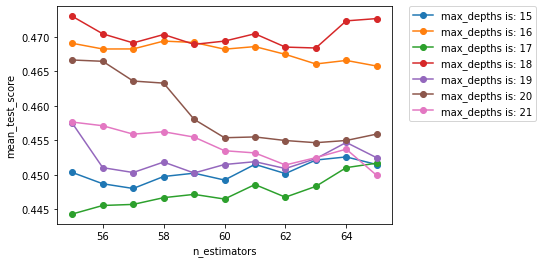

the best parameter for max_depth is: 18
the best parameter for n_estimators is: 55


In [ ]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1, 1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))

In [ ]:
# retrain randomforest regression model using the best parameter for max_depth & n_estimators, and with all training data
# rf_f is the randomforest regression model to be tested with testing data.
rf_f=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],max_features='sqrt',random_state=2,n_jobs=-1)
rf_f.fit(model_train_x,model_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=18, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=55, n_jobs=-1, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

# Part 4: Model Evaluation

## 4.1: Evaluate all models

In [ ]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [ ]:
#For lasso
from sklearn.metrics import  mean_squared_error
pred_y=lasso_f.predict(test_x)
lasso_score=lasso_f.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.10427106336624571
Mean square error of lasso:  237700167.11463308
Root mean squared error of lasso: 15417.527918399664


In [ ]:
#for ridge
from sklearn.metrics import  mean_squared_error
pred_y=ridge_f.predict(test_x)
ridge_score=ridge_f.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.11481605380240345
Mean square error of ridge:  234901836.18394238
Root mean squared error of ridge: 15326.507631679906


In [ ]:
#For randomforest regression
from sklearn.ensemble import RandomForestRegressor
pred_y=rf_f.predict(test_x)
rf_score=rf_f.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.5007279201100253
Mean square error of rf:  132492154.68188241
Root mean squared error of rf: 11510.523649334222


## 4.2 Model comparison 

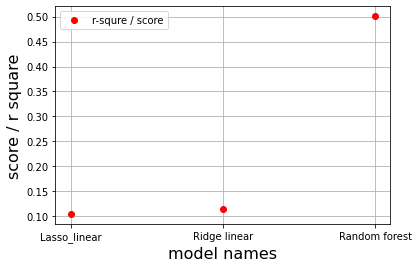

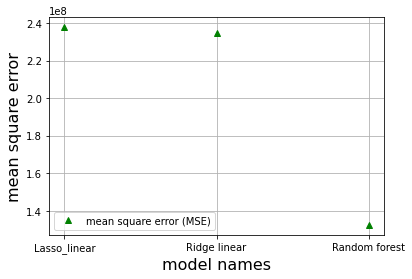

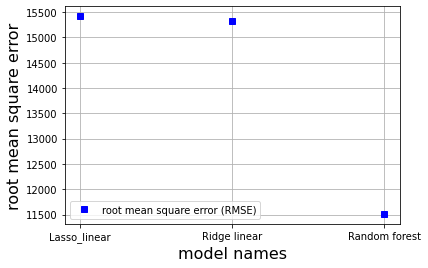

In [ ]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

By comparing R square (coefficient of determination), MSE, and RMSE, the Random Forest Regression shows the best model performance among the three.

# Part 5: Feature importance & Suggestions

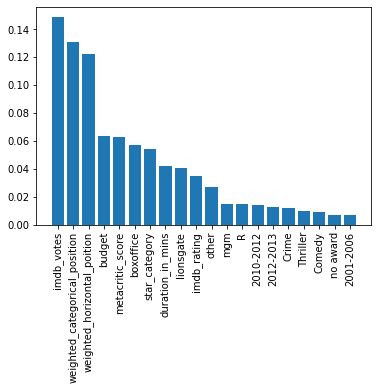

In [ ]:
importances = rf_f.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1] # return the index in sorted descending order 
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()

**Suggestions**:
1. Amazon Prime does not need to acquire licensing on too many recent movies just because of their releases are relatively more recent. Contrary to common assumption, year features '2013-2014', '2014-2017' are not among top 20 important features evaluated by random forest model;

2. Amazon Prime should focus on acquiring licensing on movies with high imdb_votes. imdb_votes, not imdb_rating, is the most important feature contributing to the cvt_per_day. So older movies with high imdb_votes are still better investment compared to newer movies with lower imdb_votes.

3. Viewers are particularly entertained by movies from Lionsgate banner, a good insight for Amazon Prime when making purchase decisions. With only 16% of videos in the Prime video pools from Lionsgate, the studio still stands out among its fellow banners.
